In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import tensorflow as tf

# tf.compat.v1.enable_eager_execution()

In [4]:
import numpy as np
import malaya_speech
import malaya_speech.config
import matplotlib.pyplot as plt

In [5]:
featurizer = malaya_speech.tf_featurization.STTFeaturizer(
    normalize_per_feature=True
)
n_mels = featurizer.num_feature_bins

In [6]:
y, sr = malaya_speech.load('../speech/example-speaker/shafiqah-idayu.wav')

In [7]:
s = featurizer.vectorize(y.astype(np.float32))
s = tf.expand_dims(s, 0)
s.shape

TensorShape([Dimension(1), Dimension(350), Dimension(80)])

In [8]:
s = tf.convert_to_tensor(s)

In [9]:
mask_emb = tf.get_variable(
    name='mask_emb',
    shape=[80],
    initializer=tf.truncated_normal_initializer(),
)

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

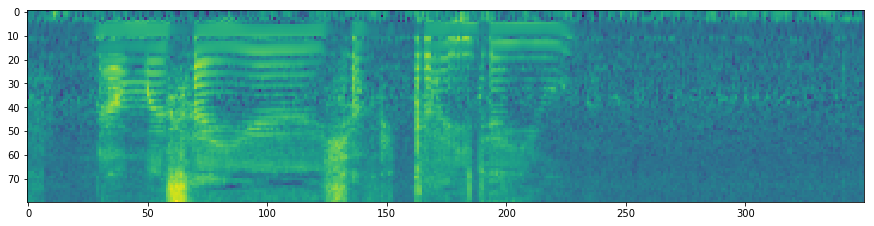

In [15]:
plt.figure(figsize = (15, 5))
plt.imshow(sess.run(s)[0].T)

In [16]:
from malaya_speech.train.model.utils import shape_list

batch_size, sequence_length, hidden_size = shape_list(s)
batch_size, sequence_length, hidden_size

(1, 350, 80)

In [17]:
from malaya_speech.train.model.masking import compute_mask_indices

In [18]:
mask_time_prob = 0.1
mask_time_length = 10
mask_time_indices = compute_mask_indices(
    (batch_size, sequence_length),
    mask_prob=mask_time_prob,
    mask_length=mask_time_length,
    min_masks=2,
)
mask_time_indices = tf.cast(mask_time_indices[:, :, tf.newaxis], tf.bool)
mask_time_indices = tf.tile(mask_time_indices, [1, 1, hidden_size])
mask_emb_ = mask_emb[tf.newaxis, tf.newaxis, :]
mask_emb_ = tf.tile(mask_emb_, [batch_size, sequence_length, 1])

In [19]:
hidden_states = tf.where(
    mask_time_indices,
    mask_emb_,
    s,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
hidden_states

<tf.Tensor 'Select:0' shape=(1, 350, 80) dtype=float32>

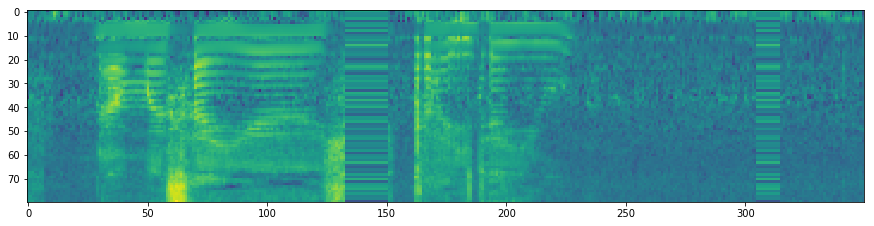

In [23]:
plt.figure(figsize = (15, 5))
plt.imshow(sess.run(hidden_states)[0].T)

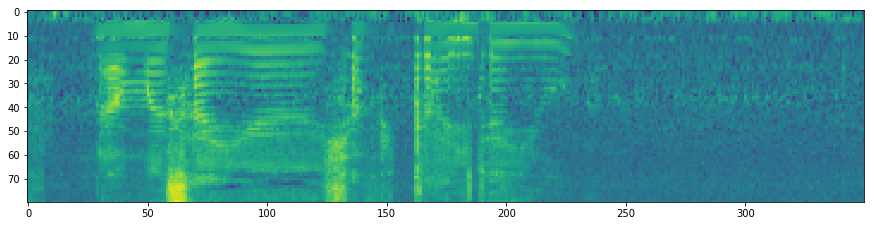

In [24]:
plt.figure(figsize = (15, 5))
plt.imshow(sess.run(s)[0].T)

In [25]:
from malaya_speech.train.model.wav2vec2.masking import compute_mask_indices, index_put, index_put_constant

In [30]:
B, T, C = shape_list(s)
padding_mask = tf.fill((B, T), False)
mask_indices = tf.compat.v1.numpy_function(
    compute_mask_indices,
    [
        (B, T),
        padding_mask,
        mask_time_prob,
        mask_time_length,
        'static',
        0,
        2,
        False,
        1,
    ],
    tf.bool,
)
mask_indices.set_shape((None, None))
x = index_put(s, mask_indices, mask_emb)

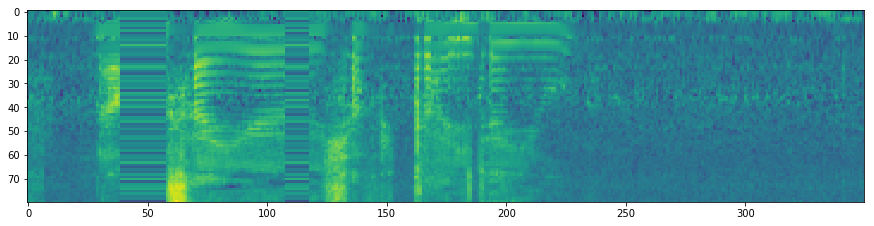

In [32]:
plt.figure(figsize = (15, 5))
plt.imshow(sess.run(x)[0].T)

In [ ]:
mask_feature_indices = compute_mask_indices(
    (batch_size, hidden_size),
    mask_prob=0.2,
    mask_length=10,
)
mask_feature_indices = tf.cast(mask_feature_indices[:, tf.newaxis, :], tf.bool)
mask_feature_indices = tf.tile(mask_feature_indices, [1, sequence_length, 1])
zeros = tf.zeros(shape = (batch_size, sequence_length, hidden_size))
hidden_states = tf.where(mask_feature_indices, zeros, hidden_states)

In [ ]:
plt.figure(figsize = (15, 5))
plt.imshow(hidden_states[0].numpy().T)